In [49]:
# Import library untuk analisis data, visualisasi, dan pemrosesan teks
import pandas as pd  # Untuk manipulasi data berbentuk DataFrame
import numpy as np  # Untuk operasi numerik
import re  # Untuk ekspresi reguler
# import nltk  # Untuk pemrosesan bahasa alami
import torch  # Untuk operasi deep learning
import seaborn as sns  # Untuk visualisasi data
import matplotlib.pyplot as plt  # Untuk pembuatan grafik
import pickle
import torch.nn.functional as F
from transformers import pipeline  # Untuk pipeline pre-built Transformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertForSequenceClassification  # Untuk model dan tokenizer Transformer
from wordcloud import WordCloud  # Untuk visualisasi WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder  # Untuk encoding label
# from datasets import Dataset  # Untuk manipulasi dataset HuggingFace
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from datasets import Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
labeled_df = pd.read_csv("sentiment-news-bahasa-v2.csv", sep=';')
labeled_df

,label,text,Unnamed: 2
0,Positive,Permohonan ini juga bertujuan memohon penjelas...,NaN
1,Positive,Projek ini bukti komitmen berterusan kerajaan ...,NaN
2,Positive,"Menerusi pembentangan Bajet 2018 yang lalu, ke...",NaN
3,Neutral,"Berdasarkan kualiti jawapan calon, 27 peratus ...",NaN
4,Positive,"Pada masa sama, kerajaan negeri juga telah bua...",NaN
...,...,...,...
3683,Positive,Kita (kerajaan negeri) tidak pernah catu.,NaN
3684,Negative,"Saya rasa, soalan disediakan telah memerangkap...",NaN
3685,Neutral,Saya perlu tengok laporan kajian sebelum membu...,NaN
3686,Negative,Kita tak lihat ia adalah satu sumbangan jitu u...,NaN


In [3]:
labeled_df = labeled_df.drop(columns=["Unnamed: 2"])
labeled_df

,label,text
0,Positive,Permohonan ini juga bertujuan memohon penjelas...
1,Positive,Projek ini bukti komitmen berterusan kerajaan ...
2,Positive,"Menerusi pembentangan Bajet 2018 yang lalu, ke..."
3,Neutral,"Berdasarkan kualiti jawapan calon, 27 peratus ..."
4,Positive,"Pada masa sama, kerajaan negeri juga telah bua..."
...,...,...
3683,Positive,Kita (kerajaan negeri) tidak pernah catu.
3684,Negative,"Saya rasa, soalan disediakan telah memerangkap..."
3685,Neutral,Saya perlu tengok laporan kajian sebelum membu...
3686,Negative,Kita tak lihat ia adalah satu sumbangan jitu u...


In [4]:
labeled_df['label'].value_counts()

label
Positive    2048
Negative     894
Neutral      746
Name: count, dtype: int64

Dilakukan Stratified Sampling untuk memastikan pembagian data secara proporsional antara kelas. Dataset dibagi rata berdasarkan label dan diacak menggunakan sample.

In [5]:
# Hitung jumlah kelas
n_classes = labeled_df['label'].nunique()

# Tentukan jumlah data per kelas
n_samples_per_class = 1000 // n_classes

# Stratified sampling
sampled_df = labeled_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=n_samples_per_class))

# Shuffle dataset
sampled_df = sampled_df.sample(frac=1).reset_index(drop=True)

# Tampilkan hasil
print(sampled_df['label'].value_counts())

label
Neutral     333
Positive    333
Negative    333
Name: count, dtype: int64


# **Preprocessing dengan BERT**

### **Membuat fungsi untuk data cleaning seperti menghapus url, hapus simbol dan karakter spesial, dll**

In [6]:
def preprocess(text):
    # Hapus URL, simbol, dan kata yang terlalu pendek
    text = re.sub(r"(https?://\S+|www\.\S+|\bhttps\b|\bt\b|\bco\b|[^a-zA-Z\s]|\b\w{1,2}\b)", " ", text)
    text = re.sub(r"\s+", " ", text).strip()  # Menghapus spasi berlebih
    
    return text

In [7]:
# Menerapkan fungsi preprocessing pada kolom teks
sampled_df['clean_text'] = sampled_df['text'].apply(preprocess)
sampled_df.head()

,label,text,clean_text
0,Neutral,"Tiap-tiap penyelidikan menunjukkan IS, penggan...",Tiap tiap penyelidikan menunjukkan pengganas p...
1,Positive,Pada saya kezaliman ini perlu diperjuangkan da...,Pada saya kezaliman ini perlu diperjuangkan da...
2,Neutral,Kami berpandangan apa yang diputuskan Mahkamah...,Kami berpandangan apa yang diputuskan Mahkamah...
3,Neutral,untuk apa?,untuk apa
4,Negative,"Daripada kajian kami lakukan, kebanyakan merek...",Daripada kajian kami lakukan kebanyakan mereka...


### **Mapping label dan split dataset**

In [8]:
# Dictionary untuk mapping
label_mapping = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

# Pemetaan label
sampled_df['label'] = sampled_df['label'].map(label_mapping)

In [9]:
sampled_df.head()

,label,text,clean_text
0,1,"Tiap-tiap penyelidikan menunjukkan IS, penggan...",Tiap tiap penyelidikan menunjukkan pengganas p...
1,2,Pada saya kezaliman ini perlu diperjuangkan da...,Pada saya kezaliman ini perlu diperjuangkan da...
2,1,Kami berpandangan apa yang diputuskan Mahkamah...,Kami berpandangan apa yang diputuskan Mahkamah...
3,1,untuk apa?,untuk apa
4,0,"Daripada kajian kami lakukan, kebanyakan merek...",Daripada kajian kami lakukan kebanyakan mereka...


In [10]:
# Pisahkan fitur dan target
X = sampled_df['clean_text']
y = sampled_df['label']

# Split dataset untuk training dan validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Agar model dapat melakukan processing, dilakukan mapping dengan menyusun label menjadi format numerik (0, 1, 2). Setelah itu dilakukan data split menjadi 80% train dan 20% val dengan stratifikasi untuk mempertahankan distribusi kelas yang seimbang.

# **Training menggunakan BERT**

In [11]:
# Menentukan perangkat yang akan digunakan (GPU atau CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Menggunakan tokenizer dan model dari distilbert-base-uncased
tokenizer = AutoTokenizer.from_pretrained("cahya/distilbert-base-indonesian")
model = AutoModelForSequenceClassification.from_pretrained("cahya/distilbert-base-indonesian", num_labels=3).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenisasi: Menggunakan tokenizer dari model BERT untuk mempersiapkan teks menjadi format yang sesuai untuk diproses oleh model.  
Memilih perangkat: Model akan dijalankan di GPU jika tersedia, jika tidak, di CPU.  
Memuat Model BERT: Menggunakan model DistilBERT pra-latih yang dioptimalkan untuk Bahasa Indonesia.

In [13]:
# Tokenisasi dataset
def tokenize_function(examples):
    tokens = tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    tokens['labels'] = examples['labels']  # Tambahkan kolom 'labels'
    return tokens

In [14]:
# Konversi ke Hugging Face Dataset dengan kolom 'labels'
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'labels': y_train}))
val_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_val, 'labels': y_val}))

In [15]:
# Tokenisasi masing-masing dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset Conversion: Dataset diubah menjadi format yang kompatibel dengan HuggingFace.  
Tokenisasi Dataset: Proses tokenisasi dilakukan pada seluruh dataset menggunakan fungsi yang telah disiapkan sebelumnya.

In [16]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",  # Direktori untuk menyimpan hasil model
    evaluation_strategy="epoch",  # Evaluasi dilakukan setiap epoch
    save_strategy="epoch",  # Model disimpan setiap epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",  # Direktori untuk menyimpan log
    save_total_limit=2,  # Maksimal 2 model yang disimpan
    load_best_model_at_end=True,  # Memuat model terbaik di akhir training
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

# Latih model
trainer.train()

c:\ProgramData\anaconda3\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.9780529141426086, 'eval_runtime': 0.4464, 'eval_samples_per_second': 448.018, 'eval_steps_per_second': 56.002, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.8854105472564697, 'eval_runtime': 0.4043, 'eval_samples_per_second': 494.624, 'eval_steps_per_second': 61.828, 'epoch': 2.0}
{'train_runtime': 18.087, 'train_samples_per_second': 88.351, 'train_steps_per_second': 11.058, 'train_loss': 0.9439325714111328, 'epoch': 2.0}


TrainOutput(global_step=200, training_loss=0.9439325714111328, metrics={'train_runtime': 18.087, 'train_samples_per_second': 88.351, 'train_steps_per_second': 11.058, 'total_flos': 52921669529088.0, 'train_loss': 0.9439325714111328, 'epoch': 2.0})

Training Arguments: Menentukan hyperparameter untuk pelatihan, seperti learning rate, jumlah epoch, ukuran batch, dll.  
Trainer: Menggunakan Trainer dari HuggingFace untuk melatih model berdasarkan data training dan validasi yang sudah disiapkan.

# **Preprocessing Unsupervised Dataset**

In [17]:
final_df = pd.read_csv("coba.csv")
final_df = final_df['text']
final_df.head()

0    ezash minggu2  baru rasa 2x  telfon sales bank...
1    o3. { #zonauang } aku open pencairan limit kre...
2    llazwd sesuai  tampilan gambar  kirimkan  kart...
3    llazwd  senang hati kami informasikan ibu llaz...
4    llazwd  senang hati kami informasikan ibu llaz...
Name: text, dtype: object

In [18]:
final_df = final_df.drop_duplicates()

In [19]:
# Ubah menjadi DataFrame dengan satu kolom
final_df = final_df.to_frame()
final_df.columns = ['text']

In [20]:
# Menerapkan fungsi untuk preprocessing pada kolom 'clean text'
final_df['clean_text'] = final_df['text'].apply(preprocess)
final_df.head()

,text,clean_text
0,ezash minggu2 baru rasa 2x telfon sales bank...,ezash minggu baru rasa x telfon sales bank man...
1,o3. { #zonauang } aku open pencairan limit kre...,zonauang aku open pencairan limit kredit spayl...
2,llazwd sesuai tampilan gambar kirimkan kart...,llazwd sesuai tampilan gambar kirimkan kartu k...
3,llazwd senang hati kami informasikan ibu llaz...,llazwd senang hati kami informasikan ibu llazw...
4,llazwd senang hati kami informasikan ibu llaz...,llazwd senang hati kami informasikan ibu llazw...


In [21]:
def tokenize_function_un(examples):
    return tokenizer(examples['clean_text'], padding='max_length', truncation=True, max_length=128)

In [22]:
# Ubah dataset menjadi format HuggingFace Dataset
unsupervised_dataset = Dataset.from_pandas(final_df[['clean_text']])

# Tokenize Dataset Menggunakan tokenize_function
unsupervised_dataset = unsupervised_dataset.map(tokenize_function_un, batched=True)

# Set Format untuk PyTorch
unsupervised_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [23]:
# Predict Sentiment
sentiment_predictions = trainer.predict(unsupervised_dataset)

  0%|          | 0/176 [00:00<?, ?it/s]

Tokenisasi: Dataset tanpa label ditokenisasi agar dapat diproses oleh model.  
Prediksi Sentimen: Model yang telah dilatih digunakan untuk memprediksi sentimen dari dataset tanpa label.

In [24]:
# Debug isi dari sentiment_predictions
print(type(sentiment_predictions))
print(len(sentiment_predictions))
print(sentiment_predictions)

# Periksa bentuk setiap elemen
for i, element in enumerate(sentiment_predictions):
    print(f"Element {i}: type={type(element)}, shape={np.array(element).shape if hasattr(element, 'shape') else 'Not an array'}")


<class 'transformers.trainer_utils.PredictionOutput'>
3
PredictionOutput(predictions=(array([[ 0.06162879,  0.17814378, -0.22506927],
       [-0.18162003,  0.42051923, -0.18122466],
       [ 0.00746695,  0.50823355, -0.6977746 ],
       ...,
       [ 0.08790244,  0.3771249 , -0.61646986],
       [ 0.01874437, -0.31832364,  0.10152727],
       [-0.45406583,  0.9819636 , -0.7472455 ]], dtype=float32), (array([[[-3.4781912e-01,  1.5632068e-01,  6.1029470e-01, ...,
          9.0203184e-01, -1.4123880e+00, -5.8035221e-02],
        [ 1.1480290e+00, -5.3330553e-01, -7.2541779e-01, ...,
          1.9170010e+00, -1.4600686e+00, -4.3733251e-01],
        [ 6.3547927e-01,  1.6584318e-03,  1.9586132e+00, ...,
         -1.5329163e-01, -8.2484759e-02, -8.1554979e-01],
        ...,
        [-3.0417323e+00, -1.5115741e+00,  1.3936270e+00, ...,
         -1.3044363e-01,  9.5030569e-02, -1.8765640e+00],
        [-2.7249267e+00, -1.5934901e+00,  1.4962533e+00, ...,
         -1.9586962e-01, -2.4915116e-01, 

Mencetak tipe dan panjang dari sentiment_predictions untuk memastikan bahwa data yang diperoleh sesuai dengan yang diharapkan.

In [25]:
# Ambil logits (elemen 0)
logits_tuple = sentiment_predictions[0]

# Debug isi tuple
print(f"Logits tuple type: {type(logits_tuple)}")
print(f"Length of logits tuple: {len(logits_tuple)}")

Logits tuple type: <class 'tuple'>
Length of logits tuple: 2


In [26]:
# Debug isi dari logits_tuple
for i, element in enumerate(logits_tuple):
    print(f"Element {i}: type={type(element)}, shape={np.array(element).shape if hasattr(element, 'shape') else 'Not an array'}")


Element 0: type=<class 'numpy.ndarray'>, shape=(1408, 3)
Element 1: type=<class 'tuple'>, shape=Not an array


Memeriksa setiap elemen dalam sentiment_predictions untuk mengetahui apakah elemen tersebut adalah array dan untuk melihat bentuk dari elemen-elemen tersebut.

In [27]:
# Ambil logits dari elemen pertama tuple
logits = logits_tuple[0]

# Debug bentuk logits
print(f"Logits shape: {logits.shape}")

Logits shape: (1408, 3)


Mengambil elemen pertama dari sentiment_predictions, yang berisi tuple, dan memeriksa tipe serta panjang tuple tersebut. Kemudian, logits (nilai yang diprediksi sebelum diterapkan fungsi aktivasi) diambil dari elemen pertama tuple dan diperiksa bentuknya.

In [28]:
# Prediksi kelas dengan probabilitas tertinggi
predictions = np.argmax(logits, axis=1)

In [29]:
# Tambahkan prediksi ke DataFrame
final_df['label'] = predictions

# Tampilkan beberapa hasil prediksi
print(final_df[['text', 'label']].head())

                                                text  label
0  ezash minggu2  baru rasa 2x  telfon sales bank...      1
1  o3. { #zonauang } aku open pencairan limit kre...      1
2  llazwd sesuai  tampilan gambar  kirimkan  kart...      1
3  llazwd  senang hati kami informasikan ibu llaz...      2
4  llazwd  senang hati kami informasikan ibu llaz...      2


Setelah memastikan bentuk logits, kode menghitung prediksi kelas dengan probabilitas tertinggi menggunakan np.argmax, dan hasil prediksi tersebut ditambahkan ke DataFrame final_df.

**Mengapa perlu dilakukan step-step tetakhir ini?**

Step-step tersebut perlu dilakukan untuk memastikan bahwa data yang diproses dan hasil prediksi dari model sesuai dengan yang diharapkan. Setiap elemen dalam sentiment_predictions bisa memiliki format yang berbeda, sehingga perlu diperiksa untuk menghindari kesalahan saat melanjutkan ke tahap berikutnya. Dengan melakukan debugging dan memeriksa bentuk data di setiap langkah, kita bisa tahu masalah apa yang terjadi misalnya apakah data yang diterima sudah dalam format yang tepat atau apakah ada kesalahan dalam struktur output. Proses ini juga membantu kita memahami bagaimana model memberikan hasil prediksi dan memastikan bahwa langkah-langkah selanjutnya (seperti pengambilan kelas dengan probabilitas tertinggi) dapat dilakukan dengan benar tanpa terjadi error.

In [30]:
final_df['label'].value_counts()

label
2    631
1    539
0    238
Name: count, dtype: int64

# **Insight**

## **Distribusi Sentimen Prediksi**

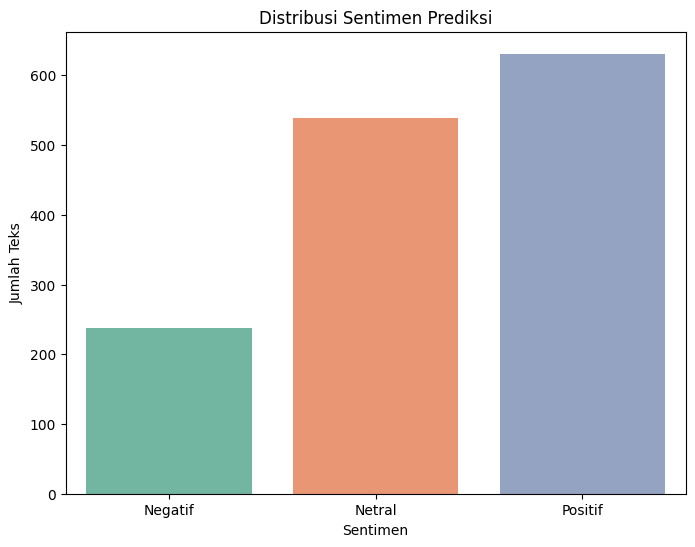

In [31]:
# Distribusi sentimen prediksi
sentiment_counts = final_df['label'].value_counts()

# Visualisasi distribusi sentimen prediksi
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=final_df, palette='Set2')
plt.title('Distribusi Sentimen Prediksi')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Teks')
plt.xticks(ticks=[0, 1, 2], labels=['Negatif', 'Netral', 'Positif'])
plt.show()

## **Analisis Word Cloud untuk Setiap Kelas Sentimen**

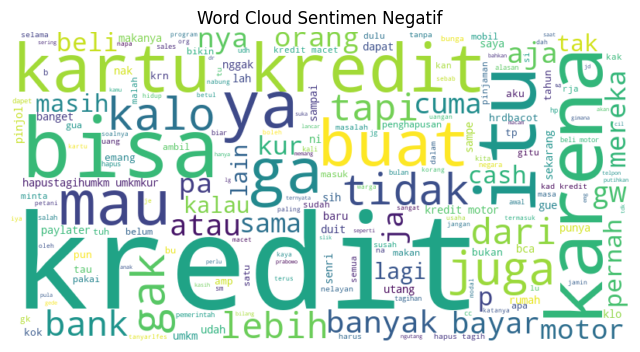

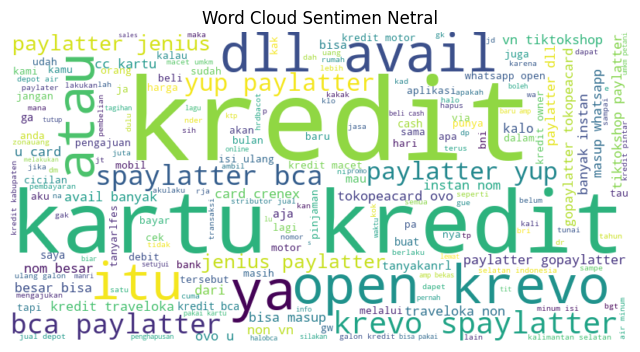

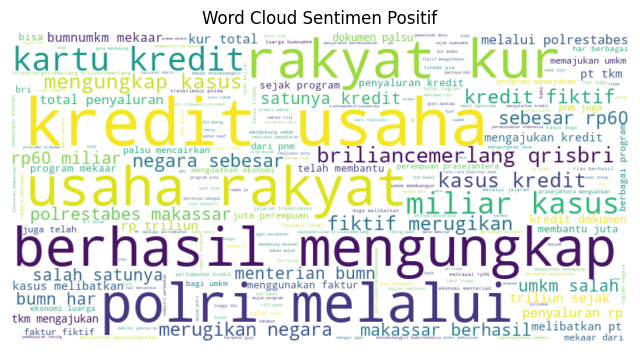

In [32]:
# Filter teks berdasarkan prediksi sentimen
negatif_text = final_df[final_df['label'] == 0]['text'].str.cat(sep=' ')
netral_text = final_df[final_df['label'] == 1]['text'].str.cat(sep=' ')
positif_text = final_df[final_df['label'] == 2]['text'].str.cat(sep=' ')

# Membuat word cloud untuk setiap kelas sentimen
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

create_wordcloud(negatif_text, 'Word Cloud Sentimen Negatif')
create_wordcloud(netral_text, 'Word Cloud Sentimen Netral')
create_wordcloud(positif_text, 'Word Cloud Sentimen Positif')

## **Top 10 Kata Dalam Setiap Sentimen**

In [33]:
# Function to extract the top N words from a text
def get_top_words(text, top_n=10):
    words = text.split()  # Split the text into individual words
    word_counts = Counter(words)  # Count the frequency of each word
    top_words = word_counts.most_common(top_n)  # Get the top N most common words
    return top_words

In [34]:
# Get top 10 words for each sentiment
top_negatif_words = get_top_words(negatif_text, top_n=10)
top_netral_words = get_top_words(netral_text, top_n=10)
top_positif_words = get_top_words(positif_text, top_n=10)

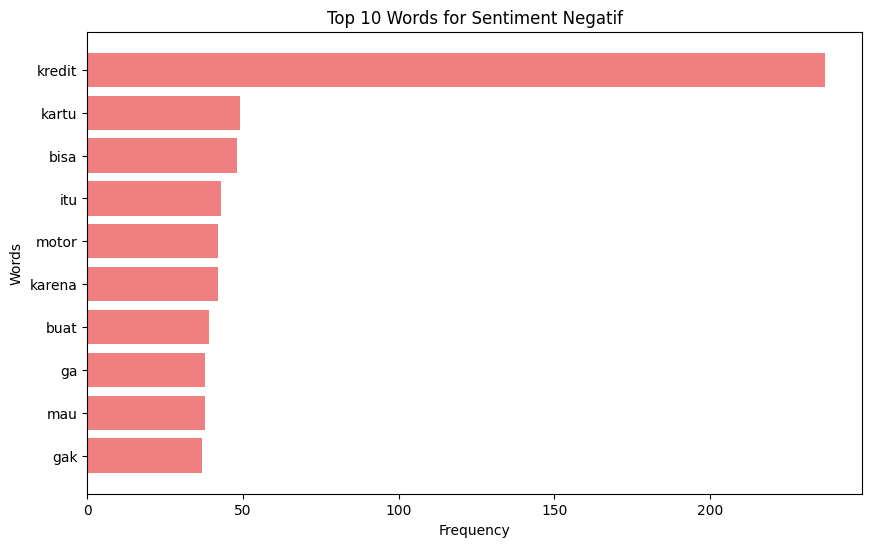

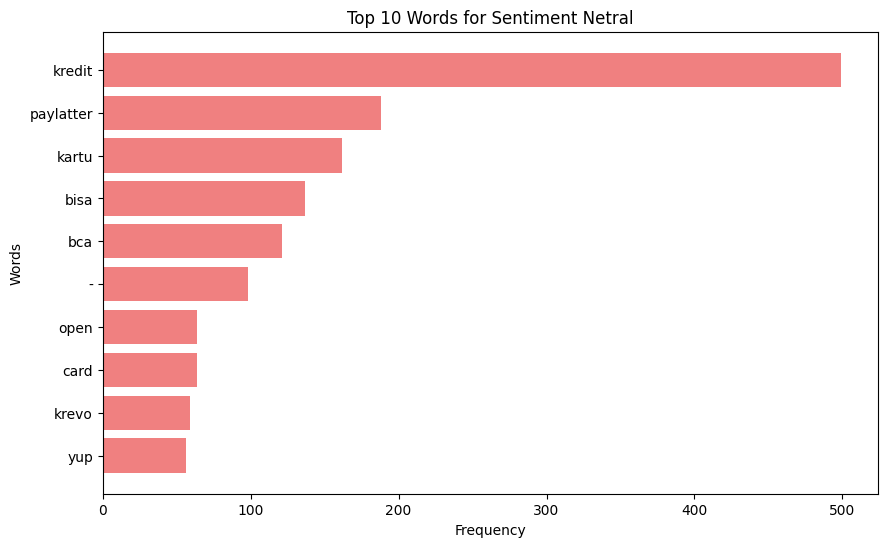

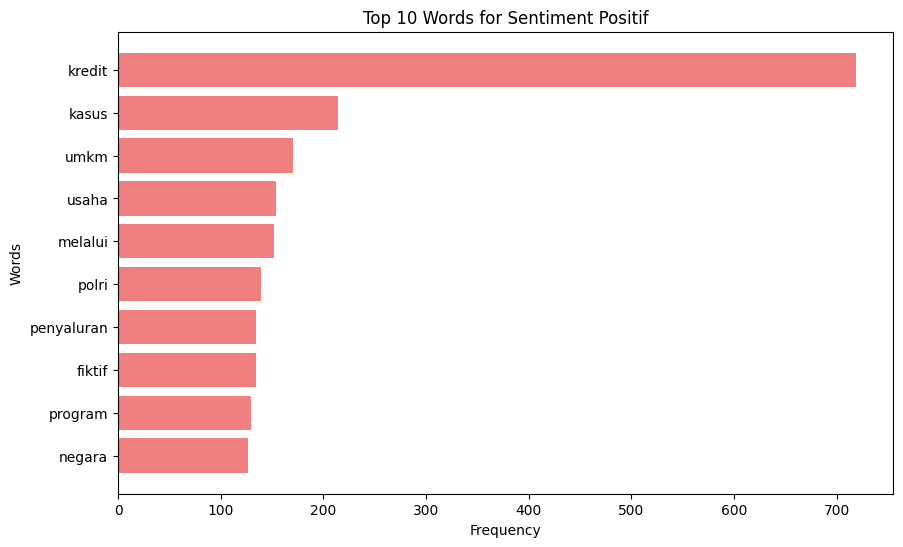

In [35]:

# Plot the top 10 words for each sentiment
def plot_top_words(top_words, sentiment_label):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='lightcoral')
    plt.title(f'Top 10 Words for Sentiment {sentiment_label}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.gca().invert_yaxis()  # To have the highest count at the top
    plt.show()

# Plot the top 10 words for each sentiment
plot_top_words(top_negatif_words, 'Negatif')
plot_top_words(top_netral_words, 'Netral')
plot_top_words(top_positif_words, 'Positif')

In [36]:
# # Ekspor DataFrame ke file CSV
# final_df.to_csv('predicted_sentiment.csv', index=False)

# print("DataFrame berhasil diekspor ke 'predicted_sentiment.csv'")

# **Train Ulang**

In [37]:
# Gabungkan Dataset
df_combined = pd.concat([sampled_df, final_df], ignore_index=True)
df_combined

,label,text,clean_text
0,1,"Tiap-tiap penyelidikan menunjukkan IS, penggan...",Tiap tiap penyelidikan menunjukkan pengganas p...
1,2,Pada saya kezaliman ini perlu diperjuangkan da...,Pada saya kezaliman ini perlu diperjuangkan da...
2,1,Kami berpandangan apa yang diputuskan Mahkamah...,Kami berpandangan apa yang diputuskan Mahkamah...
3,1,untuk apa?,untuk apa
4,0,"Daripada kajian kami lakukan, kebanyakan merek...",Daripada kajian kami lakukan kebanyakan mereka...
...,...,...,...
2402,1,tanyakanrl pa kartu kredit lebih murah,tanyakanrl kartu kredit lebih murah
2403,1,hairiyanti_ temenku beli cash harus indent. ...,hairiyanti temenku beli cash harus indent kred...
2404,1,males bgt sama kartu kredit permata soalnya na...,males bgt sama kartu kredit permata soalnya bi...
2405,2,hiliricaci generasi mreka hrus punya rumah tan...,hiliricaci generasi mreka hrus punya rumah tan...


In [38]:
X = df_combined['clean_text']
y = df_combined['label']

# Split dataset menjadi train dan validation
train_texts, val_texts, train_labels, val_labels = train_test_split(X.tolist(), y.tolist(), test_size=0.2, random_state=42)

In [39]:
# Tokenisasi dataset
def tokenize_function(clean_text):
    return tokenizer(clean_text, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

In [40]:
# Membuat dataset PyTorch
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})

In [41]:
# Definisikan TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",           # Direktori untuk menyimpan hasil
    evaluation_strategy="epoch",     # Evaluasi per epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,              # Jumlah epoch
    weight_decay=0.01,
    logging_dir="./logs",            # Direktori untuk log
    save_strategy="epoch",
    save_total_limit=2               # Simpan hanya 2 checkpoint terakhir
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Fine-tuning
trainer.train()

c:\ProgramData\anaconda3\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.4178878366947174, 'eval_runtime': 0.9774, 'eval_samples_per_second': 493.164, 'eval_steps_per_second': 31.718, 'epoch': 1.0}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.3540370762348175, 'eval_runtime': 0.9764, 'eval_samples_per_second': 493.648, 'eval_steps_per_second': 31.749, 'epoch': 2.0}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.4161875545978546, 'eval_runtime': 0.9904, 'eval_samples_per_second': 486.649, 'eval_steps_per_second': 31.299, 'epoch': 3.0}


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.46842873096466064, 'eval_runtime': 0.9645, 'eval_samples_per_second': 499.725, 'eval_steps_per_second': 32.14, 'epoch': 4.0}
{'train_runtime': 64.872, 'train_samples_per_second': 118.695, 'train_steps_per_second': 7.461, 'train_loss': 0.24359679419147082, 'epoch': 4.0}


TrainOutput(global_step=484, training_loss=0.24359679419147082, metrics={'train_runtime': 64.872, 'train_samples_per_second': 118.695, 'train_steps_per_second': 7.461, 'total_flos': 255004289971200.0, 'train_loss': 0.24359679419147082, 'epoch': 4.0})

In [42]:
results = trainer.evaluate()
print(results)

  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 0.46842873096466064, 'eval_runtime': 0.9812, 'eval_samples_per_second': 491.223, 'eval_steps_per_second': 31.593, 'epoch': 4.0}


In [43]:
# Simpan model dan tokenizer ke folder lokal
folder_name = "saved_model"
model.save_pretrained(folder_name)
tokenizer.save_pretrained(folder_name)

print(f"Model dan tokenizer telah disimpan di folder '{folder_name}'")

Model dan tokenizer telah disimpan di folder 'saved_model'


In [44]:
# Load model dan tokenizer dari folder lokal
folder_name = "saved_model"
tokenizer = AutoTokenizer.from_pretrained(folder_name)
model = AutoModelForSequenceClassification.from_pretrained(folder_name)

# Uji model dengan input
text = "Kredit menyusahkan rakyat"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
outputs = model(**inputs)

print(outputs.logits)  # Output prediksi logits

tensor([[ 3.5385, -2.4262, -1.8357]], grad_fn=<AddmmBackward0>)


In [45]:
# Terapkan softmax untuk mengubah logits menjadi probabilitas
probabilities = F.softmax(outputs.logits, dim=-1)

# Menampilkan probabilitas untuk setiap kelas
print(probabilities)

# Menampilkan kelas dengan probabilitas tertinggi
predicted_class = torch.argmax(probabilities, dim=-1).item()
print(f"Prediksi kelas: {predicted_class}")

tensor([[0.9928, 0.0025, 0.0046]], grad_fn=<SoftmaxBackward0>)
Prediksi kelas: 0


# **Modeling**

In [46]:
df = pd.read_csv('predicted_sentiment.csv')
df.head()

,full_text,clean_text,predicted_label
0,ezash minggu2 baru rasa 2x telfon sales bank...,ezash minggu baru rasa x telfon sales bank man...,1
1,o3. { #zonauang } aku open pencairan limit kre...,zonauang aku open pencairan limit kredit spayl...,1
2,llazwd sesuai tampilan gambar kirimkan kart...,llazwd sesuai tampilan gambar kirimkan kartu k...,1
3,llazwd senang hati kami informasikan ibu llaz...,llazwd senang hati kami informasikan ibu llazw...,2
4,llazwd senang hati kami informasikan ibu llaz...,llazwd senang hati kami informasikan ibu llazw...,2


In [47]:
# Ekstrak fitur dan label
X = df['clean_text']  # Teks bersih sebagai fitur
y = df['predicted_label']  # Label prediksi sebagai target

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Batasi hingga 5000 fitur untuk efisiensi
X_tfidf = vectorizer.fit_transform(X)

# Split dataset menjadi training dan testing (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [50]:
# Bangun model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 pohon keputusan

# Latih model
rf_model.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = rf_model.predict(X_test)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7695035460992907

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.22      0.34        36
           1       0.63      0.89      0.74        93
           2       0.90      0.82      0.86       153

    accuracy                           0.77       282
   macro avg       0.75      0.65      0.65       282
weighted avg       0.79      0.77      0.75       282



In [51]:
# Menggunakan SMOTE untuk menangani class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Distribusi kelas sebelum SMOTE:", np.bincount(y_train))
print("Distribusi kelas setelah SMOTE:", np.bincount(y_train_balanced))

Distribusi kelas sebelum SMOTE: [144 369 613]
Distribusi kelas setelah SMOTE: [613 613 613]


In [52]:
# Hyperparameter tuning menggunakan GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Melatih model
grid_search.fit(X_train_balanced, y_train_balanced)

# Hasil tuning
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
# Evaluasi model pada data uji
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.776595744680851

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.36      0.48        36
           1       0.65      0.90      0.75        93
           2       0.91      0.80      0.85       153

    accuracy                           0.78       282
   macro avg       0.76      0.69      0.70       282
weighted avg       0.80      0.78      0.77       282



In [53]:
# Menyimpan model ke file pickle
with open('model_rf.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model berhasil disimpan ke 'model_rf.pkl'")

Model berhasil disimpan ke 'model_rf.pkl'
